In [4]:
%load_ext autoreload
%autoreload 2

from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ, RBF

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

import high_dim_power as hd
# from high_dim_power import (
#     generate_target_proposal,
#     compute_population_quantities,
#     compute_ksd,
#     compute_analytical_power_bounds,
#     power_experiment,
# )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
tf.random.set_seed(1)

DELTA = 0.01

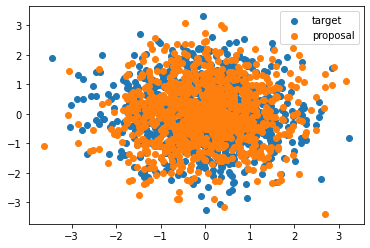

In [42]:
target, proposal = generate_target_proposal(2, DELTA)
target_x = target.sample(1000)
proposal_x = proposal.sample(1000)

fig, ax = plt.subplots()
ax.scatter(target_x[:, 0], target_x[:, 1], label="target")
ax.scatter(proposal_x[:, 0], proposal_x[:, 1], label="proposal")
ax.legend()
plt.show()

In [43]:
# dims = [1, 4, 16, 64, 256]
dims = [4, 16, 64, 128, 192, 256, 512]
res_analytical = hd.compute_population_quantities(dims, bandwidth_order=1., kernel_class=RBF)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:47<00:00, 32.52s/it]


In [44]:
tf.random.set_seed(2022)

# ns = [int(d) for d in dims]
ns = [500] * len(dims)

ksd_res = hd.compute_ksd(
    ns=ns,
    dims=dims,
    nreps=100,
    kernel_class=RBF,
    bandwidth_order=1.,
)

Repetition [100/100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:43<00:00, 23.33s/it]


# Power vs. dim

In [126]:
gamma = 1/4.
t_ratio = 0.98

res = hd.power_experiment(
    ksd_res,
    res_analytical,
    ns,
    dims,
    gamma,
    t_ratio,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 9654.76it/s]


Text(0.5, 1.0, 'upper bound')

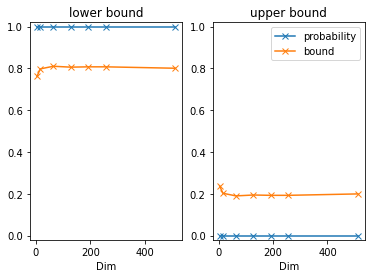

In [132]:
figs, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(res["dim"], res["probs_l"], marker="x", label="probability")
axes[0].plot(res["dim"], res["l_bd"], marker="x", label="bound")
axes[0].set_xlabel("Dim")
axes[0].set_ylim(-0.02, 1.02)
# axes[0].legend()
axes[0].set_title("lower bound")

axes[1].plot(res["dim"], res["probs_u"], marker="x", label="probability")
axes[1].plot(res["dim"], res["u_bd"], marker="x", label="bound")
axes[1].set_xlabel("Dim")
axes[1].set_ylim(-0.02, 1.02)
axes[1].legend()
axes[1].set_title("upper bound")

Text(0.5, 1.0, 'upper bound')

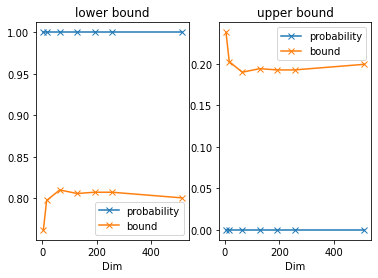

In [48]:
figs, axes = plt.subplots(nrows=1, ncols=2)

axes[0].plot(res["dim"], res["probs_l"], marker="x", label="probability")
axes[0].plot(res["dim"], res["l_bd"], marker="x", label="bound")
axes[0].set_xlabel("Dim")
axes[0].legend()
axes[0].set_title("lower bound")

axes[1].plot(res["dim"], res["probs_u"], marker="x", label="probability")
axes[1].plot(res["dim"], res["u_bd"], marker="x", label="bound")
axes[1].set_xlabel("Dim")
axes[1].legend()
axes[1].set_title("upper bound")

# Fixed n, d, varying t

In [107]:
i = 1
d = dims[i]
print("dim chosen:", d)

res_analytical_d = {
    k: v[i] for k, v in res_analytical.items()
}

ts_l = res_analytical_d["ksd"] * (1 - np.linspace(0., 0.5, 51))
ts_u = res_analytical_d["ksd"] * (1 + np.linspace(0., 0.5, 51))


res = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
)

dim chosen: 16


  0%|                                                                                                                                                                                             | 0/51 [00:00<?, ?it/s]/data/xl6116/github/pksd/high_dim_power.py:171: RuntimeWarning: divide by zero encountered in true_divide
  m2 / (n * (t_lb - ksd)**2) +
/data/xl6116/github/pksd/high_dim_power.py:172: RuntimeWarning: divide by zero encountered in double_scalars
  M2 / (n * (n - 1) * ((t_lb - ksd)**2))
/data/xl6116/github/pksd/high_dim_power.py:175: RuntimeWarning: divide by zero encountered in true_divide
  m2 / (n * (t_ub - ksd)**2) +
/data/xl6116/github/pksd/high_dim_power.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  M2 / (n * (n - 1) * ((t_ub - ksd)**2))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 20019

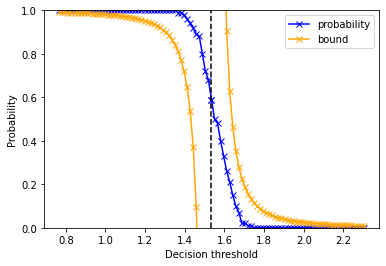

In [108]:
figs, axes = plt.subplots(nrows=1, ncols=1)

axes.plot(res["t_l"], res["probs_l"], marker="x", label="probability", color="blue")
axes.plot(res["t_u"], res["probs_u"], marker="x", color="blue")

axes.plot(res["t_l"], res["l_bd"], marker="x", label="bound", color="orange")
axes.plot(res["t_u"], res["u_bd"], marker="x", color="orange")

axes.set_xlabel("Decision threshold")
axes.set_ylabel("Probability")
axes.set_ylim(0., 1.)
axes.legend()

axes.axvline(res_analytical_d["ksd"], color="k", linestyle="--")

In [109]:
res_be = hd.power_experiment_t(
    ksd_vals=ksd_res[d],
    res_analytical=res_analytical_d,
    n=ns[i],
    ts_lb=ts_l,
    ts_ub=ts_u,
    bound="be",
)

  0%|                                                                                                                                                                                             | 0/51 [00:00<?, ?it/s]/data/xl6116/github/pksd/high_dim_power.py:192: RuntimeWarning: divide by zero encountered in true_divide
  m2 / (n*(n - 1) * (t_ub - ksd)**2) +
/data/xl6116/github/pksd/high_dim_power.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  M2**0.5 * m2 / (n**(3/2) * (n - 1)**0.5 * (t_ub - ksd)**3) +
/data/xl6116/github/pksd/high_dim_power.py:194: RuntimeWarning: divide by zero encountered in true_divide
  m3 / (n**2 * (t_ub - ksd)**3)
/data/xl6116/github/pksd/high_dim_power.py:199: RuntimeWarning: divide by zero encountered in true_divide
  m2 / (n*(n - 1) * (t_lb - ksd)**2) +
/data/xl6116/github/pksd/high_dim_power.py:200: RuntimeWarning: divide by zero encountered in double_scalars
  M2**0.5 * m2 / (n**(3/2) * (n - 1)**0.5 * np.abs(t_lb - ksd)**3) +
100%|

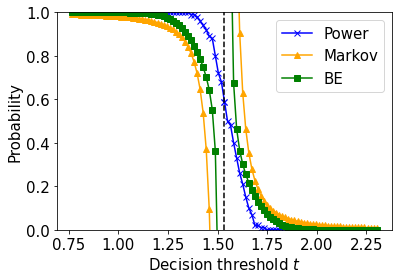

In [124]:
figs, axes = plt.subplots(nrows=1, ncols=1)

# empirical probs
axes.plot(res_be["t_l"], res_be["probs_l"], marker="x", label="Power", color="blue")
axes.plot(res["t_u"], res["probs_u"], marker="x", color="blue")

# markov bound
axes.plot(res["t_l"], res["l_bd"], marker="^", label="Markov", color="orange")
axes.plot(res["t_u"], res["u_bd"], marker="^", color="orange")

# BE bound
axes.plot(res_be["t_l"], res_be["l_bd"], marker="s", label="BE", color="green")
axes.plot(res_be["t_u"], res_be["u_bd"], marker="s", color="green")

axes.set_xlabel("Decision threshold $t$", fontsize=15)
axes.set_ylabel("Probability", fontsize=15)
axes.set_ylim(0., 1.)
axes.tick_params(labelsize=15)
axes.legend(fontsize=15)

axes.axvline(res_analytical_d["ksd"], color="k", linestyle="--")

figs.savefig("figs/power_t.pdf")